## Bank Marketing Campaign
## Data Glacier Virtual Internship
### Presented by the Greeks
### Galanakis Michalis, Konioris Aggelos, Moysiadis Giorgos

#### At first, we run the code from the previous assignment for handling missing values

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# for reproducibility
SEED = 0

In [2]:
bank_additional_full = pd.read_csv("../data/bank-additional-full.csv", delimiter = ';')
df = bank_additional_full 
df.replace('unknown', np.nan, inplace = True)
df['loan'].fillna(df['loan'].value_counts().index[0], inplace = True)
df['marital'].fillna(df['marital'].value_counts().index[0], inplace = True)
df['default'].fillna(df['default'].value_counts().index[0], inplace = True)

def na_randomfill(function):
    na = pd.isnull(function)   
    number_null = na.sum()        
    if number_null == 0:
        return function             
    fill_values = function[~na].sample(n = number_null, replace = True, random_state = 0)
    fill_values.index = function.index[na]
    return function.fillna(fill_values)

df = df.apply(na_randomfill)

#### Next, we visualize the distributions and how much of the data is filled with outliers that we may or may not, later on, remove from our dataset in the modeling phase. We create a function that will create both a basic distribution plot, and a plotbox, which is a standardized way of displaying the distribution of data based minimum/maximum, median values, and it can also tell us if our data is symmetrical, how tightly our data is grouped, and if and how our data is skewed.

In [3]:
def boxplot(attribute):
    values = df[attribute]
    mean = np.array(values).mean()
    median = np.median(values)

    f, (ax_box, ax_hist) = plt.subplots(2, sharex ='col', gridspec_kw = {'height_ratios': (0.5, 2)})

    sns.boxplot(values, ax=ax_box)
    ax_box.axvline(mean, color = 'r', linestyle = '--')
    ax_box.axvline(median, color = 'g', linestyle = '-')
    ax_box.set(xlabel = '')
    ax_box.set_title('Distribution of {}'.format(attribute), fontsize=17)

    sns.distplot(values, ax = ax_hist)
    ax_hist.axvline(mean, color = 'r', linestyle = '--')
    ax_hist.axvline(median, color = 'g', linestyle = '-')
    plt.legend({'Mean': mean,'Median': median})
    plt.show()

#### The abnormity of the data. As it can be seen from the following graphs we have very unbalanced data, following no normal distribution and with a lot of outliers.

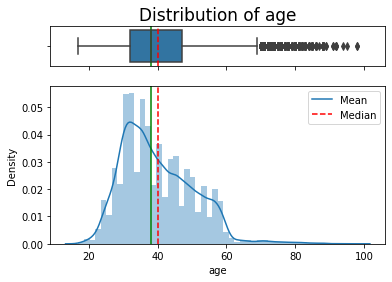

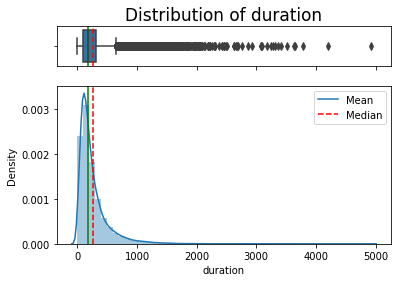

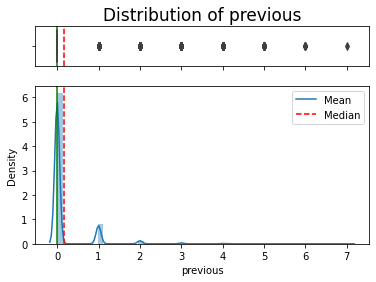

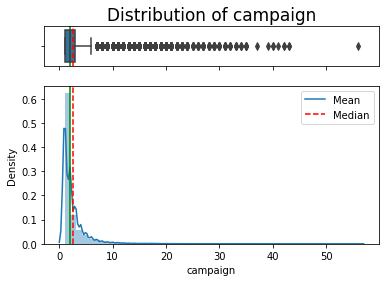

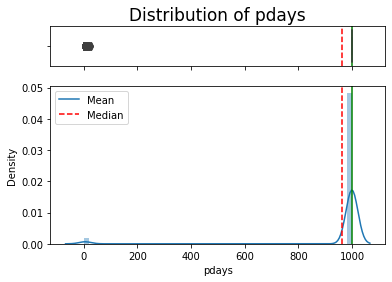

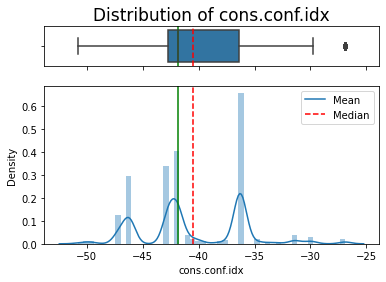

In [4]:
outliers = ['age', 'duration', 'previous', 'campaign', 'pdays', 'cons.conf.idx']
for out in outliers:
    boxplot(out)

#### A summary of our numerical variables is also provided.

In [5]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### We make a plot to see the distribution of our output variable.

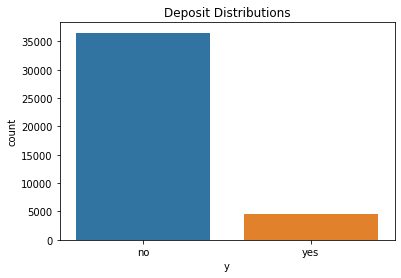

In [6]:
sns.countplot('y', data = df)
plt.title('Deposit Distributions')
plt.show()

#### The same as a table

In [7]:
df.insert(20, 'Number of Consumers', 1)
group1 = df.groupby('y').sum()[['Number of Consumers']].reset_index()
group1

,y,Number of Consumers
0,no,36548
1,yes,4640


#### From now on, we make the 7 following assumptions in order to examine the relationship between the output variable and some of the rest of the features. We start with the relationship age ~ y.

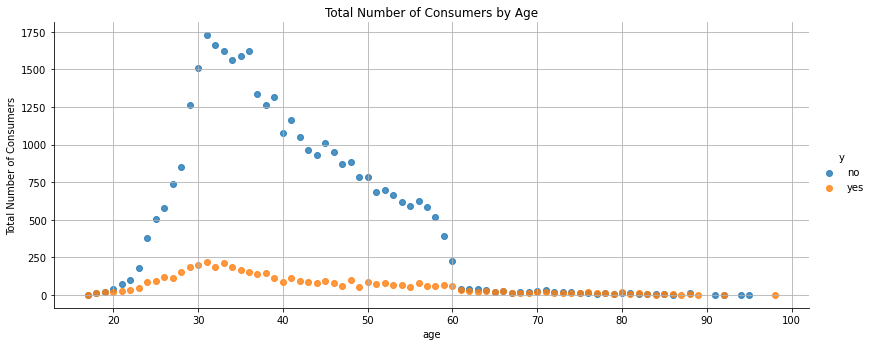

In [8]:
group2 = df.groupby(['age', 'y']).sum()['Number of Consumers'].reset_index()
sns.lmplot(x = 'age', y = 'Number of Consumers', height = 4.5, aspect = 2.5, data = group2, fit_reg = False, hue = 'y')
plt.title('Total Number of Consumers by Age')
plt.ylabel('Total Number of Consumers')
plt.grid(True)
plt.show()

#### Education ~ y

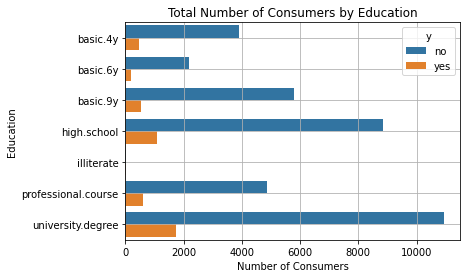

In [9]:
group2 = df.groupby(['education', 'y']).sum()['Number of Consumers'].reset_index()
sns.barplot(y = 'education', x = 'Number of Consumers', data = group2, hue = 'y')
plt.title('Total Number of Consumers by Education')
plt.xlabel('Number of Consumers')
plt.ylabel('Education')
plt.grid(True)
plt.show()

#### Month ~ y

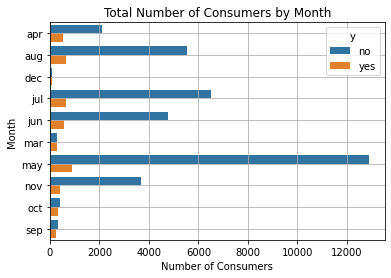

In [10]:
group3 = df.groupby(['month', 'y']).sum()['Number of Consumers'].reset_index()
sns.barplot(y = 'month', x = 'Number of Consumers', data = group3, hue = 'y')
plt.title('Total Number of Consumers by Month')
plt.xlabel('Number of Consumers')
plt.ylabel('Month')
plt.grid(True)
plt.show()

#### Job ~ y

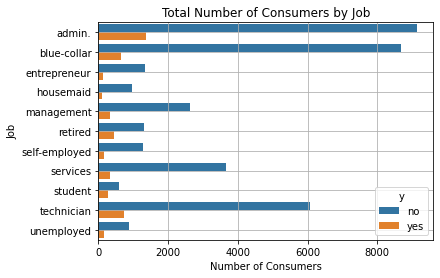

In [11]:
group4 = df.groupby(['job', 'y']).sum()['Number of Consumers'].reset_index()
sns.barplot(y = 'job', x = 'Number of Consumers', data = group4, hue = 'y')
plt.title('Total Number of Consumers by Job')
plt.xlabel('Number of Consumers')
plt.ylabel('Job')
plt.grid(True)
plt.show()

#### Cons.price.idx ~ y

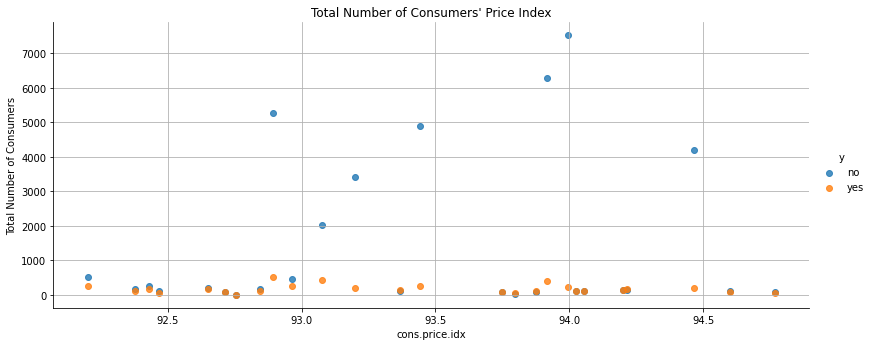

In [12]:
group5 = df.groupby(['cons.price.idx', 'y']).sum()['Number of Consumers'].reset_index()
sns.lmplot(x='cons.price.idx', y='Number of Consumers', height=4.5, aspect=2.5, data=group5, fit_reg=False, hue='y')
plt.title("Total Number of Consumers' Price Index")
plt.ylabel('Total Number of Consumers')
plt.grid(True)
plt.show()

#### Duration ~ y

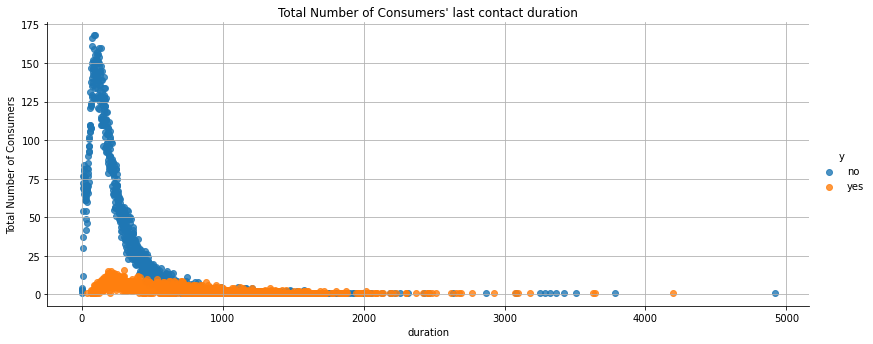

In [13]:
group6 = df.groupby(['duration', 'y']).sum()['Number of Consumers'].reset_index()
sns.lmplot(x='duration', y='Number of Consumers', height=4.5, aspect=2.5, data=group6, fit_reg=False, hue='y')
plt.title("Total Number of Consumers' last contact duration")
plt.ylabel('Total Number of Consumers')
plt.grid(True)
plt.show()

#### Poutcome ~ y 

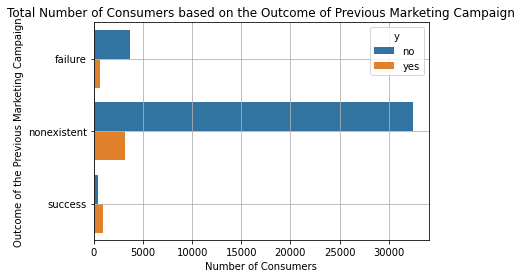

In [14]:
group7 = df.groupby(['poutcome', 'y']).sum()['Number of Consumers'].reset_index()
sns.barplot(y = 'poutcome', x = 'Number of Consumers', data = group7, hue = 'y')
plt.title('Total Number of Consumers based on the Outcome of Previous Marketing Campaign')
plt.xlabel('Number of Consumers')
plt.ylabel('Outcome of the Previous Marketing Campaign')
plt.grid(True)
plt.show()

In [15]:
obj_column = df.dtypes[df.dtypes == 'object'].index
obj_column

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [16]:
labelencoder_X = LabelEncoder()
for column in obj_column:
    df[column] = labelencoder_X.fit_transform(df[column])

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Number of Consumers,y
0,56,3,1,0,0,0,0,1,6,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0
1,57,7,1,3,0,0,0,1,6,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0
2,37,7,1,3,0,1,0,1,6,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0
3,40,0,1,1,0,0,0,1,6,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0
4,56,7,1,3,0,0,1,1,6,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0


**Dimensionality reduction** - You can think of this method as taking many features and combining similar or redundant
features together to form a new, smaller feature set.

In [17]:
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(df)

After creating and transforming our features we are going to see which are the ones that PCA saw that are the
**principal components**

In [18]:
n_pcs= pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = list(df.columns.values)

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
pc_df = pd.DataFrame(sorted(dic.items()))
pc_df

,0,1
0,PC1,duration
1,PC2,pdays
2,PC3,nr.employed


We can see that in the PCA space, the variance is maximized along **PC1**, **PC2** and **PC3**.

In [19]:
pca.explained_variance_ratio_

array([0.62679866, 0.33083918, 0.04084781])

In [20]:
# Add an interaction term of loan and housing
df['loan*housing'] = 0
df.loc[(df['loan']==1)&(df['housing']==1), 'loan*housing'] = 1

In [21]:
df['loan*housing'].value_counts()

0    37497
1     3691
Name: loan*housing, dtype: int64

Split our data in to train and test sets.

In [22]:
data = pd.get_dummies(df)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Number of Consumers,y,loan*housing
0,56,3,1,0,0,0,0,1,6,1,...,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0
1,57,7,1,3,0,0,0,1,6,1,...,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0
2,37,7,1,3,0,1,0,1,6,1,...,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0
3,40,0,1,1,0,0,0,1,6,1,...,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0
4,56,7,1,3,0,0,1,1,6,1,...,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y',axis=1), data['y'], test_size=.3, random_state=SEED,
                                                    stratify= data['y'])

Rescale our data from their default range to `0-1` range.

In [24]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model building and training

### Classification Models

* Logistic Regression : model using logistic function to predict the result
* Decision Tree Classifier : model using series decision nodes to predict the result
* Random Forest Classifier : model using multiple decision tree classifier to predict the result
* Support Vector Classifer : model using vectors to predict the result
* Gradient Boosting Classifier : model using sequence of sub-models to sequentially correct predecessor's error and improve its performance
* KNearest Classifier : model using nearest datapoints to predict the result

Training the classification models

In [25]:
models = [LogisticRegression(random_state=SEED),
          DecisionTreeClassifier(random_state=SEED),
          RandomForestClassifier(random_state=SEED),
          SVC(random_state=SEED),
          XGBClassifier(verbosity=0, random_state=SEED),
          kNN()]

results = {}

for model in models:
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    results[model.__class__.__name__] = [
        round(model.score(X_train,y_train), 2),
        round(model.score(X_test,y_test), 2),
        round(recall_score(y_test, test_pred), 2),
        round(f1_score(y_train, train_pred), 2),
        round(cross_val_score(model, X_train, y_train, cv=5).mean(), 2),
        confusion_matrix(y_train, train_pred),
        confusion_matrix(y_test, test_pred)
  ]

  # print('Train accuracy score', round(model.score(X_train,y_train), 2))
  # print('Test accuracy score', round(model.score(X_test,y_test), 2))
  # print('F1 Score', round(f1_score(y_train, model.predict(X_train)), 2))
  # print('Cross validation score', round(cross_val_score(model, X_train, y_train, cv=5).mean(), 2))
  # print()
  # print('Train confusion matrix:\n', confusion_matrix(y_train, model.predict(X_train)))
  # print('\nTest confusion matrix:\n', confusion_matrix(y_test, model.predict(X_test)))
  # print()

Results

In [26]:
index = ['train_acc', 'test_acc', 'recall', 'f1_score', 'cross_val', 'train_matrix', 'test_matrix']
results_df = pd.DataFrame(data=results, index=index, columns=list(results.keys()))
results_df

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,SVC,XGBClassifier,KNeighborsClassifier
train_acc,0.91,1.0,1.0,0.9,0.96,0.92
test_acc,0.91,0.89,0.91,0.9,0.91,0.89
recall,0.38,0.53,0.5,0.23,0.54,0.27
f1_score,0.49,1.0,1.0,0.37,0.83,0.53
cross_val,0.91,0.89,0.91,0.9,0.91,0.89
train_matrix,"[[25010, 573], [1997, 1251]]","[[25583, 0], [0, 3248]]","[[25583, 0], [0, 3248]]","[[25267, 316], [2428, 820]]","[[25317, 266], [754, 2494]]","[[25124, 459], [1915, 1333]]"
test_matrix,"[[10686, 279], [868, 524]]","[[10222, 743], [655, 737]]","[[10585, 380], [693, 699]]","[[10812, 153], [1072, 320]]","[[10526, 439], [638, 754]]","[[10637, 328], [1022, 370]]"


With recall, we can determine how many **true positives** were found by the model. The equation says:
recall = tp/(tp+fn)

We can see that half of our models fail to do that.